In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

# ⚾ PITCHf/x ⚾

PITCHf/x is a system developed by Sportvision and introduced in Major League Baseball (MLB) during the 2006 playoffs. It uses two cameras to record the position of the pitched baseball during its flight from the pitcher’s hand to home plate, and various parameters are measured and calculated to describe the trajectory and speed of each pitch. It is now instituted in all ballparks in MLB.

This version of the data used was downloaded from the `.Rdata` file provided on [this page](https://www2.stat.duke.edu/courses/Summer17/sta101.001-2/uploads/project/project.html) (direct link to [`.Rdata` file](http://stat.duke.edu/courses/Summer17/sta101.001-2/uploads/project/mondayBaseball.Rdata)).  There is also a full data dictionary on [this page](https://www2.stat.duke.edu/courses/Summer17/sta101.001-2/uploads/project/project.html).  There are many other ways to gather the data as shown in ['A new Python-based PITCHf/x parser & scraper'](https://www.beyondtheboxscore.com/2015/9/24/9374949/a-new-python-based-pitchf-x-parser-scraper) by John Choiniere.

We'll specifically be looking into predicting `pitchType`.

## EDA and Data Cleaning

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from mlxtend.plotting import plot_decision_regions
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline


data_url = "https://docs.google.com/spreadsheets/d/1pmBtSw7v_tU_dIX1-4E8_Q7wC43fDs6LGDQzN49-ffk/export?format=csv"
pitch = pd.read_csv(data_url)

<IPython.core.display.Javascript object>

In [3]:
pitch_og = pitch.copy()

<IPython.core.display.Javascript object>

Do some initial EDA to get familiar with what data we have

We have a lot of data.  We're going to take the easy way out and drop all the missing values...

In [4]:
pitch = pitch.dropna()

<IPython.core.display.Javascript object>

There's a lot of id type columns that aren't too useful for general predictions of `pitchType`.  Sure, what pitcher is throwing the ball would probably be predictive, but we want our model to work years down the road when these pitchers might not be playing anymore.  If we were wanting to update our model very often, then including pitcher might be a good feature.

Drop the id columns from our dataset

In [5]:
id_cols = [
    "gameString",
    "gameDate",
    "visitor",
    "home",
    "batterId",
    "batterName",
    "pitcherId",
    "pitcherName",
    "catcherId",
    "catcher",
    "umpireId",
    "umpire",
]

pitch = pitch.drop(id_cols, 1)

<IPython.core.display.Javascript object>

We now have essentially 3 classes of columns now:

* Before pitch - stats about batter handedness etc.
* After pitch - metrics about pitch speed etc.
* After hit - metrics about what angle the ball was hit at etc.

Let's say we're making our predictions for a broadcasting company.  Our broadcast wants to automatically display on the screen what the pitch was based on metrics we get instantaneously about the pitch's speed/movement.

Based on this, we wouldn't want to include metrics that happen after a hit. Drop the after hit columns from our dataset.

In [6]:
before_pitch_cols = [
    "inning",
    "side",
    "balls",
    "strikes",
    "outs",
    "batterHand",
    "batterPosition",
    "pitcherHand",
    "timesFaced",
]

after_pitch_cols = [
    "releaseVelocity",
    "spinRate",
    "spinDir",
    "locationHoriz",
    "locationVert",
    "movementHoriz",
    "movementVert",
]

after_hit_cols = [
    "probCalledStrike",
    "battedBallType",
    "battedBallAngle",
    "battedBallDistance",
    "paResult",
    "pitchResult",
]

pitch = pitch.drop(columns=after_hit_cols)

<IPython.core.display.Javascript object>

Look at the `head` of the dataframe again, we cutout a lot of columns so this is a much more managable view of the data.

In [7]:
pitch.head()

,inning,side,balls,strikes,outs,batterHand,batterPosition,pitcherHand,timesFaced,pitchType,releaseVelocity,spinRate,spinDir,locationHoriz,locationVert,movementHoriz,movementVert
2,1,T,0,2,0,L,CF,R,1,FF,96.5,2127.17,198.816,0.389,2.266,-5.22,9.79
5,1,T,0,2,1,L,2B,R,1,FT,98.3,2038.06,206.732,-0.206,1.430,-8.30,7.96
8,1,T,1,1,2,R,C,R,1,FF,96.3,1909.36,203.540,-0.280,1.990,-6.03,7.98
11,1,B,1,1,0,R,RF,L,1,FT,92.5,2424.90,140.242,-0.523,1.858,9.10,10.75
23,1,B,2,2,0,R,LF,L,1,FF,92.1,2319.27,138.209,-0.666,2.667,6.46,9.35


<IPython.core.display.Javascript object>

We want to predict the `pitchType`.  A dictionary has been created below to translate the abbreviations into a longer/more readable name.

In [8]:
pitch_abbr = {
    "FT": "fastball (two-seam)",
    "FF": "fastball (four-seam)",
    "FC": "fastball (cutter)",
    "FS": "fastball (splitter)",
    "SI": "sinker",
    "SL": "slider",
    "CU": "curveball",
    "KC": "knuckle-curve",
    "EP": "eephus",
    "CH": "changeup",
    "SC": "screwball",
    "KN": "knuckleball",
    "UN": "unidentified",
}

<IPython.core.display.Javascript object>

* Translate the `pitchType` column into its longer form names
* View the counts of each pitch.  
    * Instead of just printing the pitch counts.  Create a barplot of these counts.

In [9]:
pitch["pitchType"] = pitch["pitchType"].map(pitch_abbr)

<IPython.core.display.Javascript object>

In [10]:
pitch["pitchType"].value_counts()

fastball (four-seam)    4962
fastball (two-seam)     2175
changeup                1706
slider                  1448
sinker                  1051
curveball                896
fastball (cutter)        732
knuckle-curve            245
fastball (splitter)      193
unidentified              27
knuckleball                3
Name: pitchType, dtype: int64

<IPython.core.display.Javascript object>

Let's focus only on predicting some of the major classes of pitches.  Let's filter down to an arbitray list of 3 (`pitches_we_care_about`).

* Use the predefined list to filter our dataframe to only `pitchType`s in the list

In [11]:
pitches_we_care_about = ["fastball (four-seam)", "changeup", "curveball"]

<IPython.core.display.Javascript object>

In [12]:
pitch_filter = pitch["pitchType"].isin(pitches_we_care_about)
pitch = pitch[pitch_filter]

<IPython.core.display.Javascript object>

View the `shape` and `columns` to get a feel for how much data we removed from the problem.

In [13]:
pitch.shape

(7564, 17)

<IPython.core.display.Javascript object>

In [14]:
pitch.columns

Index(['inning', 'side', 'balls', 'strikes', 'outs', 'batterHand',
       'batterPosition', 'pitcherHand', 'timesFaced', 'pitchType',
       'releaseVelocity', 'spinRate', 'spinDir', 'locationHoriz',
       'locationVert', 'movementHoriz', 'movementVert'],
      dtype='object')

<IPython.core.display.Javascript object>

Make a scatter plot of `balls` x `strikes` colored by `pitchType`.  What might be a better way to view this data?

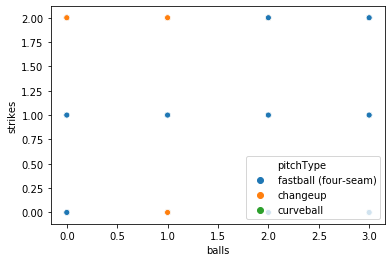

<IPython.core.display.Javascript object>

In [15]:
sns.scatterplot("balls", "strikes", hue="pitchType", data=pitch)

Make 2 separate barplots (1 for `balls` and 1 for `strikes`) colored by `pitchType`.

In [16]:
crosstab = pd.crosstab(pitch["balls"], pitch["pitchType"], normalize="columns")
crosstab.style.background_gradient()

pitchType,changeup,curveball,fastball (four-seam)
balls,,,
0,0.315358,0.389509,0.334946
1,0.374560,0.377232,0.302297
2,0.228019,0.181920,0.221685
3,0.082063,0.051339,0.141072


<IPython.core.display.Javascript object>

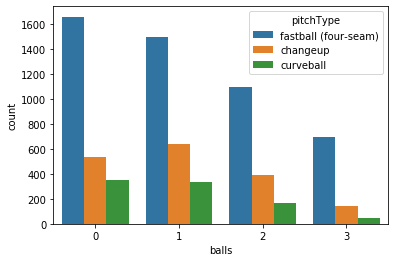

<IPython.core.display.Javascript object>

In [17]:
sns.countplot("balls", hue="pitchType", data=pitch)

The main thing I take away from these plots is that a four-seam fastball is the favorite pitch no matter what the count is.

* Make a scatterplot of `releaseVelocity` x `spinDir` colored by `pitchType`.
* Plot a horizontal line when `spinDir == 180`.
* Add transparency to the plot so you can see if an area of the plot is denser or if its just a couple of points.

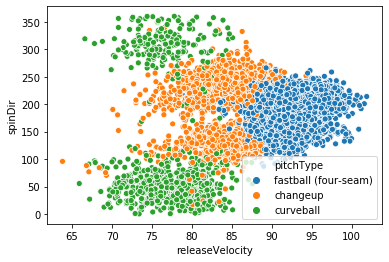

<IPython.core.display.Javascript object>

In [18]:
sns.scatterplot("releaseVelocity", "spinDir", hue="pitchType", data=pitch)

We see a mirror image in this plot... What could explain this and how might we take action on it?

* Create a new version of spin direction that is a pitch's absolute difference from 180.
* Call it `spinMag` for spin magnitude.
* Drop `spinDir` from the dataframe
* Redo the plot with `spinRate` x `spinMag`.

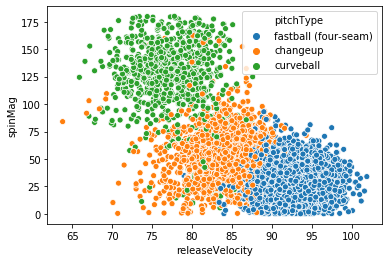

<IPython.core.display.Javascript object>

In [19]:
pitch["spinMag"] = np.abs(pitch["spinDir"] - 180)
pitch = pitch.drop("spinDir", 1)

sns.scatterplot("releaseVelocity", "spinMag", hue="pitchType", data=pitch)

This data looks linearly separable already... to have a simpler model we might just proceed with these columns only.

Advantages of this

1. It's simple to explain rather than bringing in all these additional features that are essentially dead weight if we find out we do get good predictions with just these variables.
* We can easily plot the decision boundaries if we only have 2 inputs.

## Model Prep

* Split the data into `X` and `y`
* Only use `spinMag` and `spinRate` as predictors

In [20]:
X = pitch[["spinMag", "releaseVelocity"]]
y = pitch["pitchType"]

<IPython.core.display.Javascript object>

* Perform a train/test split
    * Use 20% of the data for testing
    * Stratify the split by the class labels

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

<IPython.core.display.Javascript object>

## Model Build

Identify the data types of your features and fill out the below lists that can be used in `ColumnTransformer`.

In [22]:
# binary columns
bin_cols = []

# numeric (and ordinal columns)
num_cols = ["spinMag", "releaseVelocity"]

# categorical columns and the corresponding categories to drop from each
cat_cols = []
drop_cats = []

<IPython.core.display.Javascript object>

Create a `ColumnTransformer` to scale our numeric data.

In [23]:
preprocessing = ColumnTransformer([("scale", StandardScaler(), num_cols)])

<IPython.core.display.Javascript object>

Create a model pipeline using your `ColumnTransformer` and an `SVC`

* Use the `'linear'` `kernel`.
* Use 1.0 for the value of `C`

In [24]:
pipeline = Pipeline(
    [("preprocessing", preprocessing), ("svm", SVC(C=1.0, kernel="linear"))]
)

<IPython.core.display.Javascript object>

In [25]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessing',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('scale',
                                                  StandardScaler(copy=True,
                                                                 with_mean=True,
                                                                 with_std=True),
                                                  ['spinMag',
                                                   'releaseVelocity'])],
                                   verbose=False)),
                ('svm',
                 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma='scale', kernel='linear', max_iter=-1,
                     probability

<IPython.core.display.Javascript object>

## Model Evaluation

Score the model for both your train and test set to diagnose under/overfitting.

In [26]:
train_score = pipeline.score(X_train, y_train)
test_score = pipeline.score(X_test, y_test)

print(f"Train score: {train_score}")
print(f"Test score: {test_score}")

Train score: 0.9495951082465708
Test score: 0.9563780568407139


<IPython.core.display.Javascript object>

* Show a confusion matrix.
   * Which classes are most likely to be confused?
* Show a classification report.
   * What pitch type do we classify with the highest precision? What does that mean?

Plot the decision boundary of the model in relation to our spin predictors.

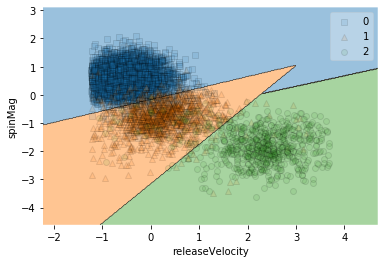

<IPython.core.display.Javascript object>

In [27]:
pitch_map = {"fastball (four-seam)": 0, "changeup": 1, "curveball": 2}

X_train_plot = preprocessing.fit_transform(X_train)
y_train_plot = y_train.replace(pitch_map)

model = SVC(C=1, kernel="linear")
model.fit(X_train_plot, y_train_plot)

plot_decision_regions(
    X_train_plot, y_train_plot.values, clf=model, scatter_kwargs={"alpha": 0.1},
)
plt.xlabel("releaseVelocity")
plt.ylabel("spinMag")
plt.show()


In [35]:
type(y_train_plot)

pandas.core.series.Series

<IPython.core.display.Javascript object>

## Hyperparameter Optimization

The main hyperparameters we toy with when fitting a `SVC` is the `kernel` and the value of `C`.  The below quotes are from [this article](https://medium.com/all-things-ai/in-depth-parameter-tuning-for-svc-758215394769) which gives a good overview of both of these hyperparameters. Additionally, the article discusses the `degree` (relevant when `kernel` is `'poly'`) and `gamma` (relevant when `kernel` is not `'linear'`).

> C is the penalty parameter of the error term. It controls the trade off between smooth decision boundary and classifying the training points correctly.

> Increasing C values may lead to overfitting the training data.

When the `kernel` is `'linear'` we won't see a huge effect when varying the value of `C`.  Its effects are more visible when we use a non-linear kernel.  Because of this, we're going to change the kernel to `'rbf'` without an explanation of what that means at this point...

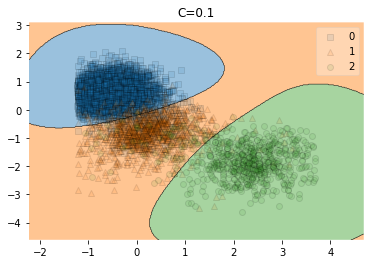

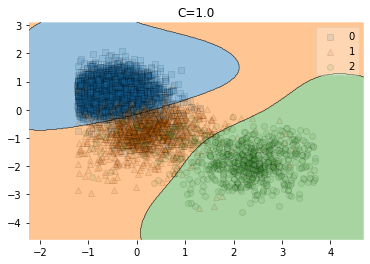

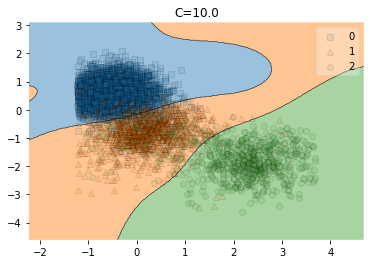

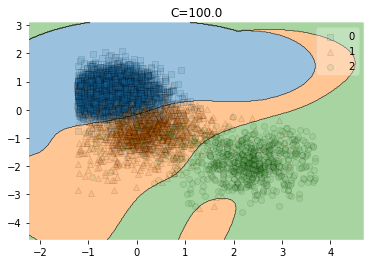

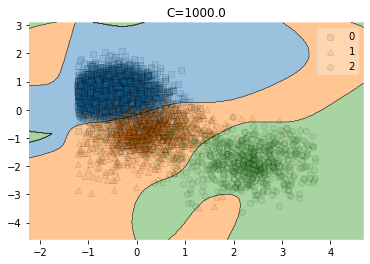

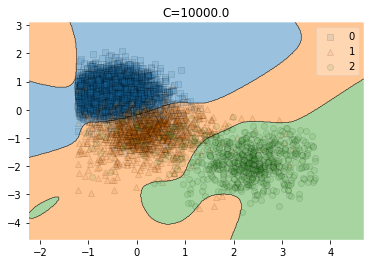

<IPython.core.display.Javascript object>

In [39]:
X_np = X_train_plot
y_np = y_train_plot.values


cs = [0, 0.1, 1, 10, 100, 1000, 10000]
# The above list can be created fancily with the below
# Read as: "go from 10^(-1) to 10^4 in 6 steps"
cs = np.logspace(-1, 4, 6)
for c in cs:
    model = SVC(kernel="rbf", C=c)
    model.fit(X_train_plot, y_train_plot)

    plot_decision_regions(X_np, y_np, clf=model, scatter_kwargs={"alpha": 0.1})
    plt.title(f"C={c}")
    plt.show()

## Aside about multiclass in `SVC`

SVMs can only draw a single decision boundary, which means that they can only separate 2 classes.  So what is `sklearn` doing that allows us to do this 3 class problem?  From [the documentation](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) we see the below description for the `decision_function_shape` parameter.

> **decision_function_shape** `‘ovo’`, `‘ovr’`, `default=’ovr’`
>    
> Whether to return a one-vs-rest (`‘ovr’`) decision function of shape (n_samples, n_classes) as all other classifiers, or the original one-vs-one (`‘ovo’`) decision function of libsvm which has shape (n_samples, n_classes * (n_classes - 1) / 2). However, one-vs-one (`‘ovo’`) is always used as multi-class strategy.

### One-vs-One (ovo)

In ovo, we just consider 2 classes at a time and then do some math to combine these multiple decision boundaries.

For example, in this data we would fit 3 models:
* curve vs fastball
* curve vs changeup
* fastball vs changeup

Each of these are then used to make predictions, and we end up with essentially a majority vote like in KNN (this is over simplified but this as a mental model is ok).

### One-vs-Rest (ovr)

In ovr, we'll just look at one of our classes as the class of interest at a time and build a model for each class.

For example, in this data we would fit 3 models:
* curve vs not-curve
* fastball vs not-fastball
* changeup vs not-changeup

Again, we'll use these sub-models to essentially vote.  This is where the analogy to voting can fall apart (what if every model predicts the 'not' class? This where some probabilities come into play).